In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import xarray as xr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

In [130]:
submission_data = pd.read_csv("data/submission_data_Stochastic_Parrots.csv")
training_data = pd.read_csv("data/training_data.csv")
nwp = xr.load_dataset("data/hres_1day_south_scotland_202101_202306.nc")
wf_capacity = pd.read_csv("data/Central Scotland Wind Farms.csv")
gb_wind_farms = pd.read_csv("data/onshore_wind_farms.csv", encoding="cp1252")

In [89]:
pd.set_option("display.max_columns", None)

In [132]:
training_data["dtm"] = pd.to_datetime(training_data.dtm, utc=True)
training_data = training_data.set_index("dtm")
training_data.head()

wind_generation_MW  solar_generation_MW  \
dtm                                                                  
2021-01-01 00:00:00+00:00             544.598                  0.0   
2021-01-01 00:30:00+00:00             534.354                  0.0   
2021-01-01 01:00:00+00:00             482.512                  0.0   
2021-01-01 01:30:00+00:00             426.260                  0.0   
2021-01-01 02:00:00+00:00             346.434                  0.0   

                           total_generation_MW  
dtm                                             
2021-01-01 00:00:00+00:00              544.598  
2021-01-01 00:30:00+00:00              534.354  
2021-01-01 01:00:00+00:00              482.512  
2021-01-01 01:30:00+00:00              426.260  
2021-01-01 02:00:00+00:00              346.434

In [4]:
wf_capacity

Name  Installed Capacity   Latitude  Longitude
0          Auchrobert Wind Farm                  36  55.623900  -3.984170
1           Andershaw Wind Farm                  35  55.530080  -3.799647
2                     Black Law                 134  55.777870  -3.707898
3   Black Law Extension Phase 1                  69  55.777870  -3.707898
4                Braes of Doune                  74  56.269829  -4.058936
5                 Clyde Central                 196  55.419488  -3.634978
6                   Clyde North                 198  55.468552  -3.595056
7                   Clyde South                 128  55.419488  -3.634978
8       Douglas West Dalquhandy                  45  55.565100  -3.872850
9         Galawhistle Wind Farm                  56  55.500000  -4.000000
10                   Harestanes                 146  55.221100  -3.573600
11                    Kype Muir                  89  55.626900  -4.032780
12                  Middle Muir                  51  55.508300  -3.800280
13                        Tullo                  17  56.835300  -2.407400
14          Tullo Wind Farm Ext                  25  56.828784  -2.425489
15                   Whitelee 1                 322  55.690000  -4.230000
16                   Whitelee 2                 238  55.687200  -4.228600

### Step 1 - Disaggregate Over Wind Farm Sites

In [5]:
gb_wind_farms_dict = {
    "Auchrobert Wind Farm": "Auchrobert Wind Farm",
    "Harestanes": "Harestanes",
    "Black Law": "Black Law",
    "Andershaw": "Andershaw Wind Farm",
    "Black Law Extension Phase 1": "Black Law Extension - 1a",
    "Braes of Doune	": "Braes O'Doune",
    "Clyde Central": "Clyde Extension",
    "Dalquhandy": "Dalquhandy Windfarm",
    "Galawhistle Wind Farm": "Galawhistle",
    "Kype Muir": "Kype Muir Wind Farm",
    "Middle Muir": "Middle Muir Wind Farm",
    "Tullo": "Tullo Farm",
    "Tullo Wind Farm Ext": "Tullo Wind Farm South (Ext.)",
    "Whitelee 1": "Whitelee",
    "Whitelee 2": "Whitelee Extension"}

gb_wind_farms.loc[gb_wind_farms["Site Name"].isin(list(gb_wind_farms_dict.values()))]

Ref ID                            Operator (or Applicant)  \
368     3116                          Scottish Power Renewables   
371     3119                                  Greencoat UK Wind   
674     3489                         CRE Energy/ Scottish Power   
784     4422                                              Eneco   
1243    4119                          Scottish Power Renewables   
1311    4189                                      Lantern Bidco   
1370    4253                          Scottish Power Renewables   
1449    4337                                   Falck Renewables   
1478    4368                        Ventient (formerly Infinis)   
1544    4440                                   Banks Renewables   
1678    3190  West Coast Energy (agents for Tullo Wind Ltd a...   
1729    4643                                   Banks Renewables   

                         Site Name Technology Type  \
368                      Black Law    Wind Onshore   
371                  Braes O'Doune    Wind Onshore   
674                       Whitelee    Wind Onshore   
784   Tullo Wind Farm South (Ext.)    Wind Onshore   
1243                    Harestanes    Wind Onshore   
1311           Dalquhandy Windfarm    Wind Onshore   
1370      Black Law Extension - 1a    Wind Onshore   
1449          Auchrobert Wind Farm    Wind Onshore   
1478                   Galawhistle    Wind Onshore   
1544         Middle Muir Wind Farm    Wind Onshore   
1678                    Tullo Farm    Wind Onshore   
1729           Kype Muir Wind Farm    Wind Onshore   

      Installed Capacity (MWelec)  Turbine Capacity (MW)  No. of Turbines  \
368                         124.0                   2.30             54.0   
371                          72.0                   2.00             36.0   
674                         322.0                   2.30            140.0   
784                          10.0                   2.50              4.0   
1243                        136.0                   2.00             68.0   
1311                         45.0                   2.00             15.0   
1370                         48.4                   1.67             29.0   
1449                         36.0                   2.50             12.0   
1478                         66.0                   3.00             22.0   
1544                         51.0                   3.40             15.0   
1678                         17.5                   2.50              7.0   
1729                         88.4                   3.40             26.0   

      Height of Turbines (m)  X-coordinate  Y-coordinate  
368                      NaN      289500.0      653500.0  
371                      NaN      272590.0      710500.0  
674                      NaN      256800.0      645435.0  
784                      NaN      375388.0      770733.0  
1243                     NaN      300000.0      595000.0  
1311                   150.0      214836.0      591232.0  
1370                     NaN      289500.0      653500.0  
1449                     NaN      275154.0      638500.0  
1478                     NaN      275440.0      629090.0  
1544                     NaN      286178.0      625826.0  
1678                     NaN      387283.0      785873.0  
1729                     NaN      271915.0      639557.0

#### Derived Features

In [7]:
def get_variable_from_netcfd(lon, lat, var, nwp=nwp):

    return (nwp[var].sel(longitude=lon, latitude = lat, method="nearest")
            .to_dataframe()
            .set_index("valid_time")[[var]]
            .resample("1800s")
            .interpolate())

get_variable_from_netcfd(-3.5, 55.5, "ws100")

ws100
valid_time                   
2021-01-02 00:00:00  5.347208
2021-01-02 00:30:00  5.537805
2021-01-02 01:00:00  5.728402
2021-01-02 01:30:00  5.920444
2021-01-02 02:00:00  6.112487
...                       ...
2023-06-30 21:00:00  7.465930
2023-06-30 21:30:00  7.930463
2023-06-30 22:00:00  8.394996
2023-06-30 22:30:00  8.745025
2023-06-30 23:00:00  9.095054

[43679 rows x 1 columns]

In [195]:
hub_heights =  {
    "Auchrobert Wind Farm": 65,
    "Andershaw Wind Farm": 65,
    "Black Law": 65,
    "Braes of Doune": 65,
    "Andershaw": 65,
    "Black Law Extension Phase 1": 65,
    "Clyde Central": 80,
    "Clyde North": 80,
    "Clyde South": 80,
    "Dalquhandy": 65,
    "Douglas West Dalquhandy": 85,
    "Galawhistle Wind Farm": 70,
    "Kype Muir": 80,
    "Harestanes": 125,
    "Middle Muir": 79,
    "Tullo": 65,
    "Tullo Wind Farm Ext": 65,
    "Whitelee 1": 65,
    "Whitelee 2": 65
}

In [196]:
nwp["ws100"] = pow(pow(nwp.u100,2) + pow(nwp.v100,2), 0.5)
nwp["ws10"] = pow(pow(nwp.u10,2) + pow(nwp.v10,2), 0.5)

nwp["angle_10"] = np.rad2deg(np.arctan2(nwp.v10, nwp.u10))
nwp["angle_100"] = np.rad2deg(np.arctan2(nwp.v100, nwp.u100))

# wind speed sheet exponent
nwp['alpha'] = np.log(nwp.ws100/nwp.ws10)/np.log(100/10)
variables = ['ws100', 'ws10', 'angle_100', 'angle_10', 'alpha']

wind_data_features = pd.DataFrame()

for index, farm in wf_capacity.iterrows():
    lon, lat = farm[["Longitude", "Latitude"]]
    weather_list = []
    for var in variables:
        weather_list.append(get_variable_from_netcfd(lon, lat, var))
    weather = pd.concat(weather_list, axis=1)
    weather['turbine'] = farm['Name']
    weather['hub_height'] = hub_heights[farm['Name']]
    weather['ws_hub'] = weather['ws10'] * pow(weather['hub_height']/10, weather['alpha'])
    weather["wa_hub"] = (weather["angle_10"] + 
                         (weather["angle_100"] - weather["angle_10"]) * (weather["hub_height"]/(10+weather["hub_height"])))
    wind_data_features = pd.concat([wind_data_features, weather])

wind_data_features.index = pd.to_datetime(wind_data_features.index, utc=True)

In [197]:
total_training_dict = {}

for var in ["ws10", "ws100", "angle_10", "angle_100"]:
    for i, row in wf_capacity.iterrows():
        lon = row["Longitude"]
        lat = row["Latitude"]
        total_training_dict.update({f"wf_{i}_{var}": get_variable_from_netcfd(lon, lat, var)[var]})

total_training_df = pd.concat(total_training_dict, axis=1)

<Axes: xlabel='valid_time'>

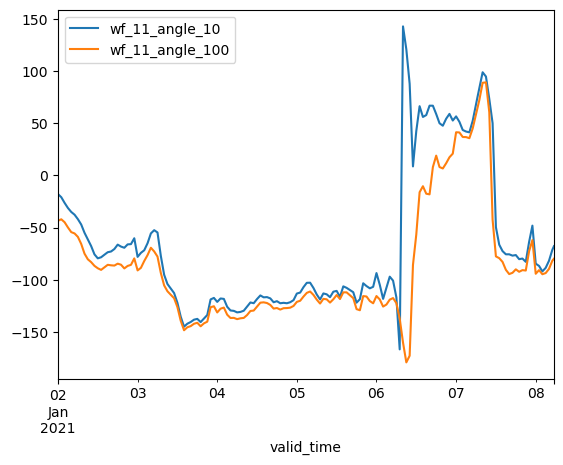

In [175]:
total_training_df[["wf_11_angle_10", "wf_11_angle_100"]].iloc[:300].plot()

#### Quantile Regression

In [70]:
wf_capacity["Installed Capacity"].sum()

1859

In [118]:
wind_data_features.head()

ws100      ws10  angle_100   angle_10     alpha  \
valid_time                                                                
2021-01-02 00:00:00  5.173418  2.989918 -43.498512 -17.887497  0.238118   
2021-01-02 00:30:00  5.375004  3.139319 -42.800743 -19.408619  0.233730   
2021-01-02 01:00:00  5.576590  3.288721 -42.102970 -20.929743  0.229342   
2021-01-02 01:30:00  5.780569  3.123513 -43.515320 -23.647194  0.267665   
2021-01-02 02:00:00  5.984549  2.958305 -44.927670 -26.364647  0.305988   

                                  turbine  hub_height    ws_hub     wa_hub  
valid_time                                                                  
2021-01-02 00:00:00  Auchrobert Wind Farm          50  4.386284 -39.230010  
2021-01-02 00:30:00  Auchrobert Wind Farm          50  4.573048 -38.902056  
2021-01-02 01:00:00  Auchrobert Wind Farm          50  4.756965 -38.574099  
2021-01-02 01:30:00  Auchrobert Wind Farm          50  4.805440 -40.203966  
2021-01-02 02:00:00  Auchrobert Wind Farm          50  4.840829 -41.833832

In [104]:
training_data[training_data.wind_generation_MW > 1850]

dtm  wind_generation_MW  solar_generation_MW  \
15823  2021-11-26T15:30:00Z           1899.6268             0.263041   
17607  2022-01-02T19:30:00Z           1926.3498             0.000000   
19139  2022-02-03T17:30:00Z           1853.5510             0.000000   
19222  2022-02-05T11:00:00Z           1858.5694            14.961292   
19230  2022-02-05T15:00:00Z           2015.7806             5.235621   

       total_generation_MW  
15823          1899.889841  
17607          1926.349800  
19139          1853.551000  
19222          1873.530692  
19230          2021.016221

<Axes: xlabel='turbine'>

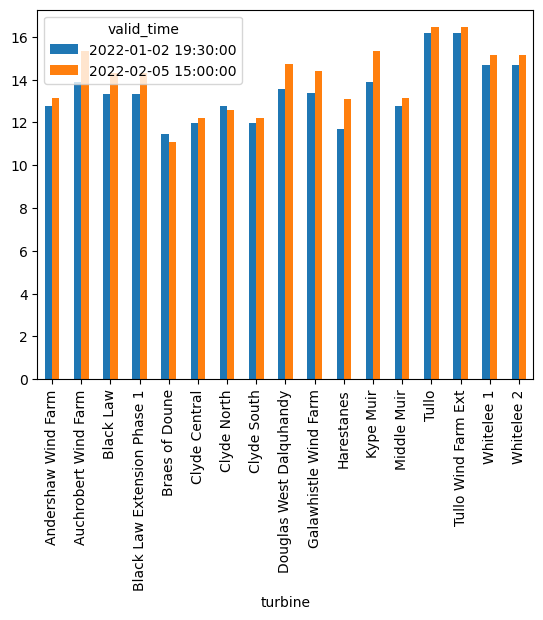

In [121]:
wind_data_features.loc[["2022-01-02 19:30:00", "2022-02-05 15:00:00"], :].reset_index().pivot(index = "turbine", columns="valid_time", values="ws100").plot.bar()

In [96]:
wind_data_features.groupby("turbine").max()["ws_hub"]

turbine
Andershaw Wind Farm            18.145305
Auchrobert Wind Farm           18.083163
Black Law                      17.409119
Black Law Extension Phase 1    17.409119
Braes of Doune                 15.410981
Clyde Central                  17.731935
Clyde North                    17.025870
Clyde South                    17.731935
Douglas West Dalquhandy        17.876900
Galawhistle Wind Farm          17.115123
Harestanes                     17.028370
Kype Muir                      18.083163
Middle Muir                    18.145305
Tullo                          24.950863
Tullo Wind Farm Ext            24.950863
Whitelee 1                     16.960342
Whitelee 2                     16.960342
Name: ws_hub, dtype: float64

In [155]:
# assume that each wind farm operates at max capacity when the wind speed is at hub speed when output = sum of capacity. 
# The power curve is cubic from the cut in to max power, so we'll assume that form and fit first on the whoke portfolio.
power_curve_data = wind_data_features.groupby(wind_data_features.index)[["ws_hub"]].mean().join(training_data[["wind_generation_MW"]]).dropna()
power_curve_data = power_curve_data[(power_curve_data.ws_hub > 3.5) & (power_curve_data.ws_hub < 25)]

poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(np.array(turbine_power_sample.ws_hub).reshape(-1, 1))

ws_hub  wind_generation_MW
valid_time                                             
2021-01-02 00:00:00+00:00  4.313829             168.738
2021-01-02 00:30:00+00:00  4.442445             184.184
2021-01-02 01:00:00+00:00  4.567869             196.626
2021-01-02 01:30:00+00:00  4.690347             174.188
2021-01-02 02:00:00+00:00  4.804674             155.108
...                             ...                 ...
2022-12-31 21:30:00+00:00  6.537162             825.848
2022-12-31 22:00:00+00:00  6.580778             767.696
2022-12-31 22:30:00+00:00  6.705622             769.064
2022-12-31 23:00:00+00:00  6.824464             809.050
2022-12-31 23:30:00+00:00  6.844272             802.732

[28528 rows x 2 columns]

In [ ]:
turbine_power_curve_models = dict()
turbine_power_samples = dict()

total_capacity = wf_capacity["Installed Capacity"].sum()

for turbine in wind_data_features.turbine.unique():
    
    turbine_capacity = wf_capacity[wf_capacity.Name == turbine]["Installed Capacity"].values[0]
    turbine_peak_ws = wind_data_features[wind_data_features.turbine == turbine].loc["2022-02-05 15:00:00", "ws_hub"]
    
    turbine_power_sample = power_curve_data[power_curve_data.ws_hub <= turbine_peak_ws]
    turbine_power_sample["wind_generation_MW"] = turbine_power_sample["wind_generation_MW"] * (turbine_capacity/total_capacity)

    turbine_wind_sample = (
        wind_data_features[
            (wind_data_features.turbine == turbine) & 
            (wind_data_features.index.isin(turbine_power_sample.index))
            ]
        .dropna()
        .ws_hub
    )

    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly_features = poly.fit_transform(np.array(turbine_wind_sample).reshape(-1, 1))

    poly_reg_model = ElasticNet()
    poly_reg_model.fit(poly_features, turbine_power_sample.wind_generation_MW)

    turbine_power_curve_models.update({turbine: poly_reg_model})

    predictions = poly_reg_model.predict(poly_features)

    turbine_power_samples[turbine] = pd.DataFrame({"ws_hub": turbine_wind_sample,
                                                   "actual_mw": turbine_power_sample.wind_generation_MW, 
                                                   "predicted_mw": predictions},
                                                   index=turbine_power_sample.index)


In [ ]:
def predict_from_power_curve(model, wind_speed, cut_out_speed):

    poly_features = poly.fit_transform(np.array(turbine_wind_sample).reshape(-1, 1))
    poly_reg_model.fit(poly_features, turbine_power_sample.wind_generation_MW)

    initial_redict = poly_reg_model.predict(poly_features)

In [206]:
turbine = "Harestanes"

px.line(turbine_power_samples[turbine][["actual_mw", "predicted_mw"]])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=actual_mw<br>valid_time=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'actual_mw',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'actual_mw',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2021, 1, 2, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 1, 2, 0, 30, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 1, 2, 1, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2022, 12, 31, 22, 30, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 12, 31, 23, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 12, 31, 23, 30, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'xaxis': 'x',
              'y': array([13.25215062, 14.46523077, 15.44238623, ..., 60.39986229, 63.54023669,
                          63.04404088]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=predicted_mw<br>valid_time=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'predicted_mw',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'predicted_mw',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2021, 1, 2, 0, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 1, 2, 0, 30, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2021, 1, 2, 1, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2022, 12, 31, 22, 30, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 12, 31, 23, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2022, 12, 31, 23, 30, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'xaxis': 'x',
              'y': array([52.02875097, 50.98749001, 49.93755472, ..., 50.5735278 , 51.86702218,
                          48.22217842]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'valid_time'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})